In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [2]:
historic_df = pd.read_csv(r'Base de Dados//Dados Históricos - Ibovespa.csv', parse_dates=['Data'], index_col='Data')
historic_df = historic_df.sort_index()

historic_df['Var%'] = historic_df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

historic_df['Vol.'] = historic_df['Vol.'].str.replace(',', '.')
historic_df['Vol.'] = historic_df['Vol.'].apply(
    lambda x: float(str(x)[:-1].replace(',', '.'))/1_000  if str(x)[-1] == 'K'
    else float(str(x)[:-1].replace(',', '.')) if str(x)[-1] == 'M'
    else float(str(x)[:-1].replace(',', '.')) * 1_000 if str(x)[-1] == 'B'
    else float(str(x).replace(',', '.'))/1_000_000 )

historic_df.rename(columns={'Vol.':'Vol (M)'}, inplace=True)

C:\Users\dhlui\AppData\Local\Temp\ipykernel_4268\3671609938.py:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  historic_df = pd.read_csv(r'Base de Dados//Dados Históricos - Ibovespa.csv', parse_dates=['Data'], index_col='Data')


In [3]:
historic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2023-01-02 to 2025-03-17
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    550 non-null    float64
 1   Abertura  550 non-null    float64
 2   Máxima    550 non-null    float64
 3   Mínima    550 non-null    float64
 4   Vol (M)   550 non-null    float64
 5   Var%      550 non-null    float64
dtypes: float64(6)
memory usage: 30.1 KB


In [4]:
historic_df.describe()

,Último,Abertura,Máxima,Mínima,Vol (M),Var%
count,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000
mean,121.529976,121.491845,122.316922,120.733245,918.218364,0.036691
std,9.002357,9.007406,8.917136,9.071973,3043.315581,0.974496
min,97.926000,97.926000,99.258000,96.997000,4.330000,-3.150000
25%,115.940000,115.910750,116.929750,115.500250,9.070000,-0.577500
50%,124.307000,124.247000,124.898500,123.414500,10.760000,0.015000
75%,128.158000,128.154000,128.983000,127.405500,13.275000,0.650000
max,137.344000,137.349000,137.469000,136.664000,24870.000000,4.290000


In [5]:
delta_date = historic_df['Último'].iloc[-1] - historic_df['Último'].iloc[0]
line_trend = delta_date/(len(historic_df)-1)

historic_df['Trend'] = (line_trend * range(len(historic_df))) + historic_df['Último'].iloc[0]

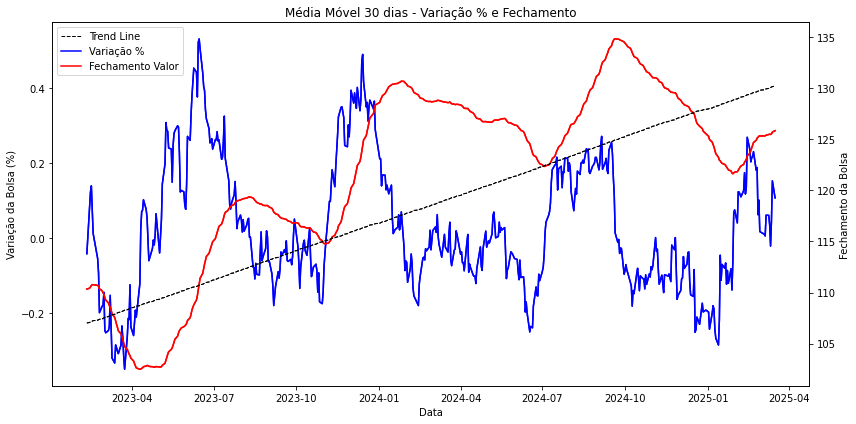

In [6]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot da média móvel da variação percentual no eixo primário
line1, = ax.plot(historic_df.index, historic_df['Var%'].rolling(window=30).mean(), color='blue', label='Variação %')
ax.plot(historic_df.index, historic_df['Var%'].rolling(window=30).mean(), color='blue', label='Variação %')
ax.set_xlabel('Data')
ax.set_ylabel('Variação da Bolsa (%)')
ax.tick_params(axis='y')

# Criação do segundo eixo Y (para o fechamento da bolsa)
ay = ax.twinx()
line2, = ay.plot(historic_df.index, historic_df['Último'].rolling(window=30).mean(), color='red', label='Fechamento Valor')
ay.plot(historic_df.index, historic_df['Último'].rolling(window=30).mean(), color='red', label='Fechamento Valor')
line3, = ay.plot(historic_df.index, historic_df['Trend'].rolling(window=30).mean(), 
                 color='black', linewidth=1, linestyle='--', label='Trend Line')
ay.plot(historic_df.index, historic_df['Trend'].rolling(window=30).mean(),
         color='black', linewidth=1, linestyle='--', label='Trend Line')
ay.set_ylabel('Fechamento da Bolsa')
ay.tick_params(axis='y')

# Título e layout
lines = [line3, line1, line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')

plt.title('Média Móvel 30 dias - Variação % e Fechamento')
fig.tight_layout()

# Exibir gráfico
plt.show()

In [7]:

historic_df

,Último,Abertura,Máxima,Mínima,Vol (M),Var%,Trend
Data,,,,,,,
2023-01-02,106.376,109.734,109.734,105.981,8.13,-3.06,106.37600
2023-01-03,104.166,106.377,106.684,103.852,14.47,-2.08,106.42055
2023-01-04,105.334,104.167,105.627,103.915,14.45,1.12,106.46510
2023-01-05,107.641,105.336,107.743,105.333,15.51,2.19,106.50965
2023-01-06,108.964,107.642,109.433,107.642,12.63,1.23,106.55420
...,...,...,...,...,...,...,...
2025-03-11,123.507,124.519,124.625,122.636,8810.00,-0.81,130.65580
2025-03-12,123.864,123.507,124.048,122.969,8250.00,0.29,130.70035
2025-03-13,125.637,123.863,125.774,123.590,11260.00,1.43,130.74490


In [8]:
historic_var_df = historic_df[['Var%']]
X = historic_var_df[['Var%']].values

result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")


Teste ADF
Teste Estatístico: -23.161072729288584
P-Value: 0.0
Valores críticos:
	1%: -3.4423174665535385
	5%: -2.866818952732754
	10%: -2.569581505602171


In [9]:
# Define training and test sets
train_end = '2025-03-01'
df_train = historic_df.loc[:train_end]
df_test = historic_df.loc[train_end:]

### CRIANDO O NAIVE PREDICT

In [10]:
naive_pred = pd.Series(index=historic_df.index, dtype='float64')
naive_pred.loc[df_train.index] = historic_df['Último'].shift(1).loc[df_train.index]
last_train_value = historic_df['Último'].loc[df_train.index[-1]]
naive_pred.loc[df_test.index] = last_train_value


# Evaluation
from sklearn.metrics import mean_squared_error

mse_naive = mean_squared_error(df_test['Último'][1:], naive_pred.loc[df_test.index][1:])
print(f'Naive Baseline MSE: {mse_naive}')

Naive Baseline MSE: 15.05531237499996


### CRIANDO XGBoost PREDICT

Period: 550.0 days


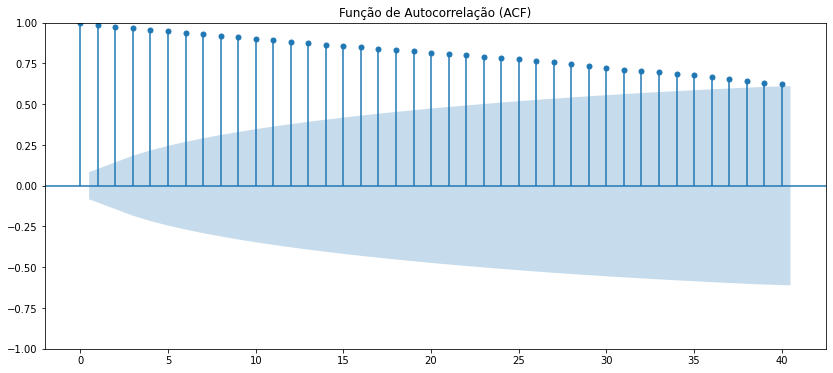

In [12]:
historic_df['day'] = historic_df.index.day
historic_df['week_of_year'] = [dt.weekofyear for dt in historic_df.index]
historic_df['month'] = historic_df.index.month
historic_df['year'] = historic_df.index.year


# Plot da ACF e PACF da série diferenciada
plt.figure(figsize=(14, 6))
plot_acf(historic_df["Último"].dropna(), ax=plt.gca(), lags=40)
plt.title("Função de Autocorrelação (ACF)")


n_lags = 40
for lag in range(1, n_lags + 1):
    historic_df[f'lag_{lag}'] = historic_df['Último'].shift(lag)


# Rolling statistics
historic_df[f'rolling_mean_{n_lags}'] = historic_df['Último'].rolling(window=n_lags).mean().shift(1)
historic_df[f'rolling_std_{n_lags}'] = historic_df['Último'].rolling(window=n_lags).std().shift(1)

# Exponential Moving Averages (EMA)
historic_df[f'ema_{n_lags}'] = historic_df['Último'].ewm(span=n_lags).mean().shift(1)
historic_df[f'ema_std_{n_lags}'] = historic_df['Último'].ewm(span=n_lags).std().shift(1)



from scipy.signal import periodogram
frequency, power = periodogram(historic_df['Último'].dropna(), fs=1)

freq = frequency[np.argmax(power)]
period = 1 / freq

print(f'Period: {period} days')

historic_df['fourier_sin'] = np.sin(2 * np.pi * freq * np.arange(len(historic_df)))
historic_df['fourier_cos'] = np.cos(2 * np.pi * freq * np.arange(len(historic_df)))


predictors = [
    'day',
    'week_of_year',
    'month',
    'year',
    *['lag_{}'.format(i) for i in range(1, n_lags + 1)],
    'rolling_mean_{n_lags}'.format(n_lags=n_lags),
    'rolling_std_{n_lags}'.format(n_lags=n_lags),
    'ema_{n_lags}'.format(n_lags=n_lags),
    'ema_std_{n_lags}'.format(n_lags=n_lags),
    'fourier_sin',
    'fourier_cos',
]



In [13]:
df_train = historic_df.loc[:train_end]
df_test = historic_df.loc[train_end:]

# Define features and target
X_train = df_train[predictors]
y_train = df_train['Último']
X_test = df_test[predictors]
y_test = df_test['Último']

# TimeSeriesSplit for validation
tscv = TimeSeriesSplit(n_splits=100)
xgb = XGBRegressor(objective='reg:squarederror')

# Train with cross-validation
xgb_models = []
mse = []
count = 0
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb.fit(X_tr, y_tr)
    val_pred = xgb.predict(X_val)
    # print(f'{count} Validation MSE: {mean_squared_error(y_val, val_pred)}')
    count = count + 1 
    mse.append(mean_squared_error(y_val, val_pred))
    xgb_models.append(xgb)

best_model_idx = mse.index(min(mse))
print(f'Best Model Idx: {best_model_idx}')

xgb = xgb_models[best_model_idx]

# Predict on the test set
xgb_pred = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, xgb_pred)
print(f'XGBoost MSE: {mse_xgb}')

Best Model Idx: 85
XGBoost MSE: 2.4276048568343946


In [14]:
xgb_pred_series = pd.Series(xgb_pred, index=df_test.index, name='pred')
xgb_pred_df = xgb_pred_series.astype('float64')

xgb_pred_df

Data
2025-03-05    122.809532
2025-03-06    124.230537
2025-03-07    124.769135
2025-03-10    125.484207
2025-03-11    125.047630
2025-03-12    124.919579
2025-03-13    124.395851
2025-03-14    125.812187
2025-03-17    128.573395
Name: pred, dtype: float64

### CRIANDO ARIMA PREDCT

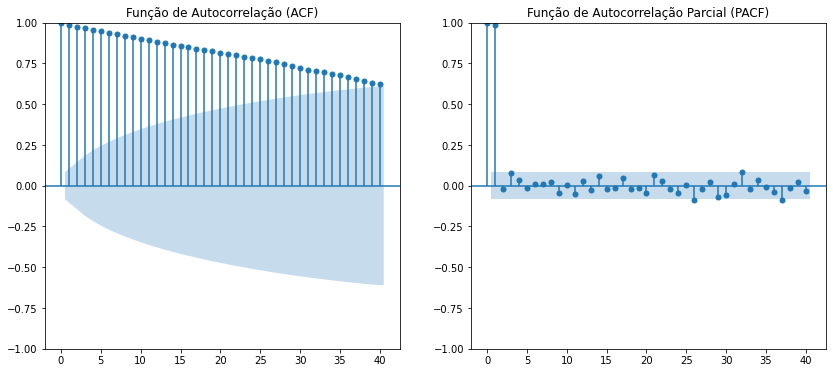

In [16]:
# Plot da ACF e PACF da série diferenciada
plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_acf(historic_df["Último"].dropna(), ax=plt.gca(), lags=40)
plt.title("Função de Autocorrelação (ACF)")
plt.subplot(122)
plot_pacf(historic_df["Último"].dropna(), ax=plt.gca(), lags=40)
plt.title("Função de Autocorrelação Parcial (PACF)")
plt.show()

In [17]:
p = 3 
d = 1
q = 40

model_arima = ARIMA(df_train["Último"], order=(p, d, q))
resultado_arima = model_arima.fit()

arima_pred = resultado_arima.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1)

arima_mse = mean_squared_error(y_test, arima_pred)
print(f'ARIMA MSE: {arima_mse}')

c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization

ARIMA MSE: 10.299340727517688


c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [18]:
arima_pred.index = df_test.index 
arima_pred_series = pd.Series(arima_pred, index=df_test.index, name='pred')
arima_pred_df = arima_pred_series.astype('float64')

arima_pred_df


Data
2025-03-05    122.947099
2025-03-06    123.843921
2025-03-07    123.553491
2025-03-10    123.946944
2025-03-11    123.561493
2025-03-12    123.176676
2025-03-13    123.112457
2025-03-14    123.365418
2025-03-17    123.635989
Name: pred, dtype: float64

12:47:08 - cmdstanpy - INFO - Chain [1] start processing
12:47:08 - cmdstanpy - INFO - Chain [1] done processing


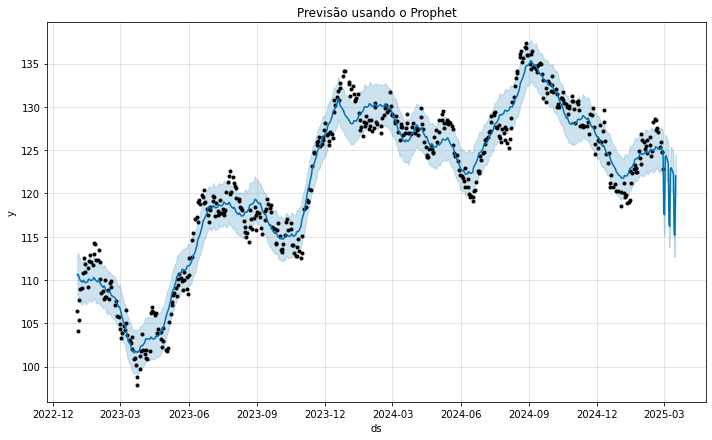

In [69]:
data = df_train[['Último']].copy()
data['ds'] = data.index

data.rename(columns={'Último': 'y'}, inplace=True)

delta_days = (df_test.index[-1]-df_train.index[-1]).days


from prophet import Prophet

# Ajustando o modelo Prophet com o seu DataFrame
model = Prophet()
model.fit(data)

# Gerando o futuro para o número de dias calculado
future = model.make_future_dataframe(periods=delta_days)

# Fazendo a previsão
prophet_pred = model.predict(future)


fig = model.plot(prophet_pred)

# Exibindo o gráfico
plt.title('Previsão usando o Prophet')
plt.show()

prophet_pred.set_index('ds', inplace=True)
prophet_pred_series = pd.Series(prophet_pred['yhat'], index=df_test.index, name='pred')
prophet_pred_df = prophet_pred_series.astype('float64')


### TESTE DE CONFIABILIDADE

In [70]:

mae_naive = mean_absolute_error(df_test['Último'], naive_pred[train_end:])
rmse_naive = mean_squared_error(df_test['Último'], naive_pred[train_end:])
mape_naive = 100 * mean_absolute_percentage_error(df_test['Último'], naive_pred[train_end:])

mae_xgb = mean_absolute_error(df_test['Último'], xgb_pred)
rmse_xgb = mean_squared_error(df_test['Último'], xgb_pred)
mape_xgb = 100 * mean_absolute_percentage_error(df_test['Último'], xgb_pred)

mae_arima = mean_absolute_error(df_test['Último'], arima_pred)
rmse_arima = mean_squared_error(df_test['Último'], arima_pred)
mape_arima = 100 * mean_absolute_percentage_error(df_test['Último'], arima_pred)

mae_prophet = mean_absolute_error(df_test['Último'], prophet_pred.loc[df_test.index]['yhat'])
rmse_prophet = mean_squared_error(df_test['Último'], prophet_pred.loc[df_test.index]['yhat'])
mape_prophet = 100 * mean_absolute_percentage_error(df_test['Último'], prophet_pred.loc[df_test.index]['yhat'])



resultados = pd.DataFrame(
    {
        "Modelo": ["XGBoost", "Naive", "Arima", "Prophet"],
        "MAE": [mae_xgb, mae_naive, mae_arima, mae_prophet],
        "RMSE": [rmse_xgb, rmse_naive, rmse_arima, rmse_prophet],
        "MAPE (%)": [mape_xgb, mape_naive, mape_arima, mape_prophet],
        "Accuracy (%)": [
            100 - mape for mape in [mape_xgb, mape_naive, mape_arima, mape_prophet]
        ],
    }
).sort_values("MAPE (%)").reset_index(drop=True)

resultados


,Modelo,MAE,RMSE,MAPE (%),Accuracy (%)
0,XGBoost,1.287095,2.427605,1.015787,98.984213
1,Arima,2.077260,10.299341,1.618383,98.381617
2,Naive,2.618556,13.389334,2.048097,97.951903
3,Prophet,2.781438,15.641417,2.174470,97.825530


C:\Users\dhlui\AppData\Local\Temp\ipykernel_4268\2711941687.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic_filter['Trend'] = (line_trend * range(len(historic_filter))) + historic_filter['Último'].iloc[0]


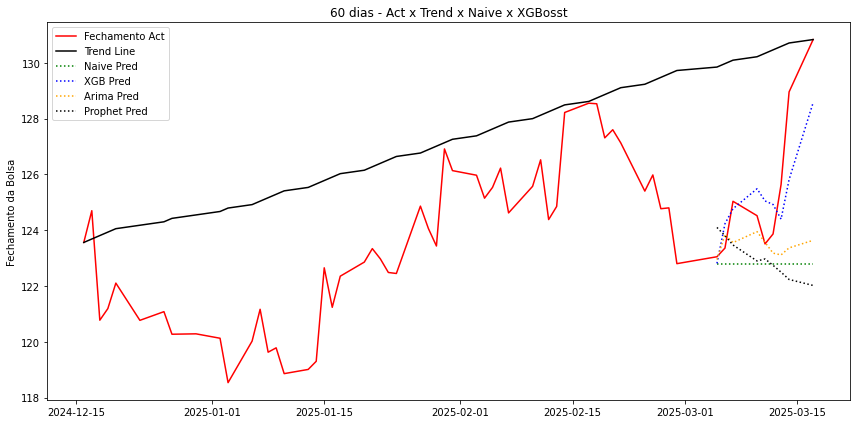

In [75]:
historic_filter = historic_df.tail(60)
delta_date = historic_filter['Último'].iloc[-1] - historic_filter['Último'].iloc[0]
line_trend = delta_date/(len(historic_filter)-1)
historic_filter['Trend'] = (line_trend * range(len(historic_filter))) + historic_filter['Último'].iloc[0]

naive_filter = naive_pred.tail(60)


fig, ax = plt.subplots(figsize=(12,6))

# Fechamento act
line2, = ax.plot(historic_filter.index, historic_filter['Último'], color='red', label='Fechamento Act')

# Linha de tendência
line3, = ax.plot(historic_filter.index, historic_filter['Trend'], 
                 color='black', label='Trend Line')

# Previsão Naive 
line4, = ax.plot(df_test.index, naive_filter.loc[df_test.index], color='green', linestyle=':', linewidth=1.5, label='Naive Pred')

# Previsão XGBoost
line5, = ax.plot(df_test.index, xgb_pred_df.loc[df_test.index], color='blue', linestyle=':', linewidth=1.5, label='XGB Pred')

# Previsão Arima
line6, = ax.plot(df_test.index, arima_pred_df.loc[df_test.index], color='orange', linestyle=':', linewidth=1.5, label='Arima Pred')

# Previsão Prophet
line7, = ax.plot(df_test.index, prophet_pred_df.loc[df_test.index], color='black', linestyle=':', linewidth=1.5, label='Prophet Pred')

ax.set_ylabel('Fechamento da Bolsa')
ax.tick_params(axis='y')

# Título e legenda
lines = [line2, line3, line4, line5, line6, line7]  # A lista de objetos de linha
# Usando get_label() corretamente
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')

plt.title('60 dias - Act x Trend x Naive x XGBosst')
fig.tight_layout()

plt.show()